<a href="https://colab.research.google.com/github/rkatophys/contour-calculation/blob/main/contour_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install libsuitesparse-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsuitesparse-dev is already the newest version (1:5.10.1+dfsg-4build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
!pip install --upgrade numpy==2.0 scipy scikit-sparse enterprise_extensions enterprise-pulsar --no-cache-dir

In [3]:
!git clone https://github.com/rkatophys/contour-calculation.git contourcalc

fatal: destination path 'contourcalc' already exists and is not an empty directory.


In [4]:
import os
os.environ["JAX_ENABLE_X64"] = "True"
import ast
import numpy as np
import scipy.linalg as linalg
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import joblib
from healpy.newvisufunc import projview, newprojplot
from copy import copy

import jax
import jax.numpy as jnp
import inspect
import re

from enterprise_extensions import deterministic
from enterprise.signals import utils

In [5]:
# Get the source code of the original function and apply replacement
text = inspect.getsource(utils).replace("import numpy as np", "import jax.numpy as np")
# Write the modified source code to file
with open("utils_jnp.py", "w") as file:
    file.write(text)

In [6]:
# Get the source code of the original function
text = inspect.getsource(deterministic)

# Define replacement rules (order matters)
replacements = [
    ("import numpy as np", "import jax.numpy as np"),
    (
        "from enterprise.signals import deterministic_signals, parameter, signal_base, utils",
        "from enterprise.signals import deterministic_signals, parameter, signal_base\nimport utils"
    ),
    ("utils", "utils_jnp"),
    ("cos_gwtheta=0,", "gwtheta=0,"),
    ("cos_inc=0,", "inc=0,"),
    ("gwtheta = np.arccos(cos_gwtheta)", ""),
    ("inc = np.arccos(cos_inc)", ""),
    ("if p_dist > 0:", "if True:")
]

# Apply all replacements
for old, new in replacements:
    text = text.replace(old, new)

# Write the modified source code to file
with open("deterministic_jnp.py", "w") as file:
    file.write(text)


In [7]:
import utils_jnp
import deterministic_jnp
import contourcalc.script.pta_contour as pta_contour

In [8]:
NSIDE = 6
NPIX = hp.nside2npix(NSIDE)

# Pixel indices
pixel_indices = np.arange(NPIX)

# Convert pixel indices to spherical coordinates (theta, phi)
thetas, phis = hp.pix2ang(NSIDE, pixel_indices, nest=False)

In [9]:
# Load pulsar data and distance data from CSV files
datadf = pd.read_csv("./contourcalc/data/psr_data_list.csv")   # Basic information such as RA/Dec
distdf = pd.read_csv("./contourcalc/data/psr_dist_list.csv")   # Distance and its uncertainty information

# Keep only the necessary columns in distdf and rename them (for clarity after merging)
distdf_renamed = distdf.rename(columns={
    "NOW +σd [pc]": "pdist_sigma_now",
    "SKA +σd [pc]": "pdist_sigma_ska"
})[["psr", "pdist_sigma_now", "pdist_sigma_ska"]]

# Merge the two dataframes on "psr" (pulsar name) using a left join based on datadf
# For pulsars without distance info, NaN will be filled
# After merging, sort by "NOW +σd [pc]" (uncertainty of current distance)
merged_df = pd.merge(datadf, distdf_renamed, on="psr", how="left").sort_values("pdist_sigma_now")

# Extract each column as NumPy arrays (useful for fast computation and later processing)
psr_names = merged_df["psr"].to_numpy()                      # List of pulsar names
psr_radecs = merged_df[["ra", "dec"]].to_numpy()             # Right ascension and declination [rad]
psr_pdists_sigma_now = merged_df["pdist_sigma_now"].to_numpy()  # uncertainty of current distance [pc]
psr_pdists_sigma_ska = merged_df["pdist_sigma_ska"].to_numpy()  # uncertainty of distance with SKA [pc]

# Get the number of pulsars (total count of pulsar names)
lenpsrs = len(psr_names)

# Create a random permutation of indices from 0 to lenpsrs-1 using a RNG with seed 0,
# then reorder this permutation array according to the original row indices of merged_df
psr_seeds = np.random.default_rng(seed=0).permutation(lenpsrs)[merged_df.index.to_numpy()]

In [10]:
white_seed = 0           # Seed for the white noise random number generator
white_sigma = 10 * 1e-9  # Standard deviation of white noise [seconds]

period = 12.5            # Observation duration of the pulsar [years]
cadence = 3              # Observation cadence of the pulsar [weeks]

calc_snr = False         # Flag to calculate SNR or not
folder = "cov_mean"      # Output folder name

In [11]:
# Set default distance to 1.0 kpc and distance uncertainty to 0.1 kpc for all pulsars
pdists_dict = {
    psr_name: {"pdist": 1.0, "pdist_sigma": 0.1}  # 1000 pc = 1 kpc
    for psr_name in psr_names
}

# Override distance and uncertainty for J0437-4715 from merged_df (converted to kpc)
pdist0437_dict = {
    "J0437-4715": {
        "pdist": 1.0,
        "pdist_sigma": (
            merged_df.loc[merged_df["psr"] == "J0437-4715", "pdist_sigma_now"].values[0] * 1e-3
        ),
    }
}

# Override distance and uncertainty for J0030+0451 from merged_df (converted to kpc)
pdist0030_dict = {
    "J0030+0451": {
        "pdist": 1.0,
        "pdist_sigma": (
            merged_df.loc[merged_df["psr"] == "J0030+0451", "pdist_sigma_now"].values[0] * 1e-3
        ),
    }
}

# Update the default distances with the specific overrides
pdists_dict.update(pdist0437_dict)
pdists_dict.update(pdist0030_dict)

# Create a list of DummyPsr objects for each pulsar
psrs_list = []
for i in range(lenpsrs):
    psr = pta_contour.DummyPsr(
        psr_names[i],
        psr_radecs[i],
        psr_seeds[i],
        period=period,
        cadence=cadence,
        pdist=pdists_dict[psr_names[i]]["pdist"],
        pdist_sigma=pdists_dict[psr_names[i]]["pdist_sigma"],
        white_sigma=white_sigma,
        white_seed=white_seed,
    )
    psrs_list.append(psr)

# Convert the list of pulsars into a NumPy array
psrs = np.array(psrs_list)


In [12]:
# Run loop_func in parallel over all pixels (indexed by i)
# n_jobs=1: run with a single worker (no real parallelism, can increase if desired)
# prefer="threads": use threading backend (can help with I/O or Python-bound tasks)
# joblib.delayed: defers the execution of loop_func until called by Parallel
# Takes ~10 minutes to execute with calc_snr = False
result = joblib.Parallel(n_jobs=1, prefer="threads")(
    joblib.delayed(pta_contour.loop_func)(angnum, psrs, thetas, phis, white_sigma, folder, calc_snr) for angnum in range(len(phis))
)

In [13]:
means = []  # List to store mean vectors loaded from files
covs = []   # List to store covariance matrices loaded from files

for i in range(len(phis)):
    # Load the mean vector for the i-th pixel from file
    mean = np.loadtxt(f"{folder}/mean_{i}.txt")
    # Load the covariance matrix for the i-th pixel from file
    cov = np.loadtxt(f"{folder}/cov_{i}.txt")

    means.append(mean)  # Append loaded mean to the list
    covs.append(cov)    # Append loaded covariance to the list

/usr/local/lib/python3.11/dist-packages/healpy/newvisufunc.py:535: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=left, right=right, top=top, bottom=bottom)


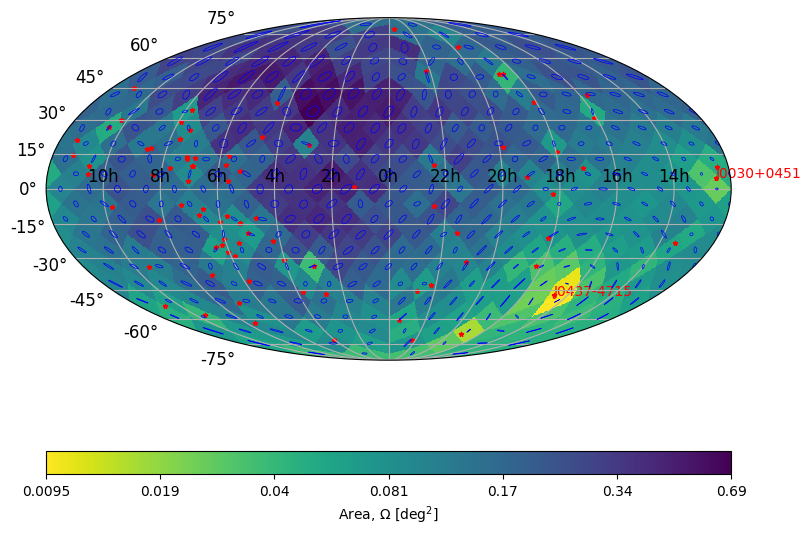

In [14]:
prob_area = 0.68  # Probability for 68% confidence region
prob_contour = 1.0 - 10.0**-15.0  # Nearly 100% probability for contour plotting

# Create a name of ra axis
time24s = 2 * (np.arange(12))[::-1]
timeh = np.roll([f"{str(time24)}h" for time24 in time24s], -5)[1:]

fig, ax = plt.subplots(figsize=[8, 16], rasterized=True, layout='constrained')

ellipses_list = []
areas_list = []

for i in range(len(phis)):
    mean = means[i][:2][::-1]  # (phi, theta)
    cov = covs[i][:2][::-1, ::-1]  # ((phi, theta), (phi, theta))
    phi = mean[0]
    theta = mean[1]

    # Rotate angles for plotting
    rotphi, rottheta = pta_contour.ang_rot(phi, theta)

    # Perform SVD on covariance to get ellipse orientation and size
    width, height, angle = pta_contour.get_ellipse_params_from_cov(cov)

    # Create ellipse for the probability contour
    ellipse = Ellipse(
        xy=[rotphi, rottheta],
        width=width * pta_contour.prob_chisq(prob_contour),
        height=height * pta_contour.prob_chisq(prob_contour),
        angle=angle,
        facecolor="none",
        edgecolor="blue",
        alpha=1.0,
        zorder=2.0,
        lw=0.5,
    )

    new_ellipse = copy(ellipse)

    # Calculate ellipse area for 68% confidence region
    area = np.pi * (width * pta_contour.prob_chisq(prob_area) / 2.0) * (height * pta_contour.prob_chisq(prob_area) / 2.0)
    ellipses_list.append(new_ellipse)
    areas_list.append(area)

# Calculate spherical area (deg^2)
properareas = np.array(areas_list) * (180.0 / np.pi) ** 2 * np.sin(thetas)

# Visualize with Mollweide projection
projview(
    properareas,
    coord=["G"],
    rot=(180, 0, 0),
    flip="astro",
    graticule=True,
    graticule_labels=True,
    projection_type="mollweide",
    longitude_grid_spacing=30,
    latitude_grid_spacing=15,
    custom_xtick_labels=timeh,
    hold=True,
    cbar=False,
    cmap="viridis_r",
    alpha=1.0,
    zorder=0.0,
    norm="log",
    extend="neither",
)

# Configure colorbar
im = fig.axes[0].collections[0]
cbar = plt.colorbar(
    im,
    ax=fig.axes[0],
    ticks=np.logspace(np.log10(np.min(properareas)), np.log10(np.max(properareas)), 7),
    format="{x:.2g}",
    location="bottom",
    orientation="horizontal",
    aspect=30,
    shrink=1.0,
)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label=r"Area, $\Omega$ $[{\rm deg}^2]$", size=10)

# Add ellipses to plot
ax = plt.gca()
for ellipse in ellipses_list:
    ax.add_artist(ellipse)

# Plot pulsar positions with red stars
for psr in psrs:
    pphi = psr.pixels[1]
    ptheta = psr.pixels[0]
    rotpphi, rotptheta = pta_contour.ang_rot(pphi, ptheta)
    ax.scatter(
        rotpphi,
        rotptheta,
        marker="*",
        facecolor="red",
        edgecolors="red",
        s=10,
        zorder=1.0,
    )
    # Display names for specific pulsars
    if psr.name in ["J0437-4715", "J0030+0451"]:
        ax.text(
            rotpphi,
            rotptheta,
            psr.name,
            size=10,
            color="red",
            zorder=1.0,
        )

plt.show()
